# Análise das notícias sob a ótica ESG 

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import datetime  as dt
from scipy import interpolate
import scipy.stats
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from ipynb.fs.full.noticias_timeline import plota_timeline
from ipynb.fs.full.noticias_processamento_texto import remove_acentos, remove_termos_comuns, aplica_stemming_texto, remove_palavras_texto, conta_termos_esg, classifica_texto, classifica_textos_coletados, filtra_noticias_nao_relacionadas, filtra_noticias_sem_classificacao, conta_mencoes_empresas, filtra_citacao_relevante, trim_texto
from ipynb.fs.full.vaderSentimentptbr import SentimentIntensityAnalyzer 
from ipynb.fs.full.sumarizador_textrankptbr import summarize_text_rank 
import re


warnings.filterwarnings('ignore')
base_noticias = 'base_noticias.xlsx'
df = pd.read_excel(base_noticias)

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/danielsaraivaleite/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielsaraivaleite/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pré-processamento da base de notícias
- Realiza filtro
- Resume o texto pelo algoritmo TextRank (Mihalcea, 2014): https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

In [2]:
# filtros pos processamento (exclusoes)
def filtrar_noticias_pos_coleta(dfNoticias):
    dfFiltrado = filtra_citacao_relevante(noticias=dfNoticias, empresa='', listagem_empresas=[], threshold=1.1, aceitar_titulo=False, recalcular_contagem=False)
    dfFiltrado = dfFiltrado[dfFiltrado['empresa'] != 'sao carlos'] # termos comuns demais

    dfPadroesExcluir = pd.read_excel('palavras_chave_excluir_empresa.xlsx')
    dfFiltrado['excluir_texto'] = False
    dfFiltrado['excluir_titulo'] = False

    padrao = ''
    for emp in dfPadroesExcluir['empresa'].unique():
        lista_termos = list(  (dfPadroesExcluir[ dfPadroesExcluir['empresa'] == emp]['termo_excludente'].str.lower()) )
        lista_termos = [remove_acentos(t) for t in lista_termos]
        #lista_termos = [re.escape(t) for t in lista_termos]
        padrao = '|'.join(  lista_termos  ) 
        
        # filtra termos que sao associados incorretamente com uma empresa e sao falsos relevantes no texto
        dfFiltrado['excluir_texto'] =  ((dfFiltrado['excluir_texto']) | ((dfFiltrado['empresa'] == emp) & (dfFiltrado['texto_completo'].apply(remove_acentos).str.lower().str.contains(padrao, regex=True))))

        # filtra termos que sao associados incorretamente com uma empresa e sao falsos relevantes no titulo
        dfFiltrado['excluir_titulo'] =  ((dfFiltrado['excluir_titulo']) | ((dfFiltrado['empresa'] == emp) & (dfFiltrado['titulo'].apply(remove_acentos).str.lower().str.contains(padrao, regex=True))))
        
    
    dfFiltrado = dfFiltrado[~ dfFiltrado['excluir_texto'] ] 
    del dfFiltrado['excluir_texto']
    
    dfFiltrado = dfFiltrado[~ dfFiltrado['excluir_titulo'] ] 
    del dfFiltrado['excluir_titulo']
    
    return dfFiltrado

df = filtrar_noticias_pos_coleta(df)

# resume o texto filtrando partes nao relevantes

df['resumo'] = df['texto_completo'].apply(lambda x : summarize_text_rank(x, compression=0.8, include_first_parag=True))

## Aplicação do algoritmo de análise de sentimento VADER adaptado ao português
Referências:
Gilbert, CJ Hutto Eric. 2014. Vader: A parsimonious rule-based model for sentiment analysis of social media text.
Eighth International Conference on Weblogs and Social Media (ICWSM-14). Disponível em: <http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf>


In [3]:
s = SentimentIntensityAnalyzer() 
df['polaridade_texto'] = df['resumo'].apply(lambda x : s.polarity_scores(x)['compound'] )
df['polaridade_titulo'] = df['titulo'].apply(lambda x : s.polarity_scores(x)['compound'] )

# pondera heuristicamente titulo e texto
df['polaridade'] = 0.2 * df['polaridade_titulo'] + 0.8 * df['polaridade_texto']

df.to_excel('sentimento_'+base_noticias, index=False)

## Descrevendo o conjunto de dados

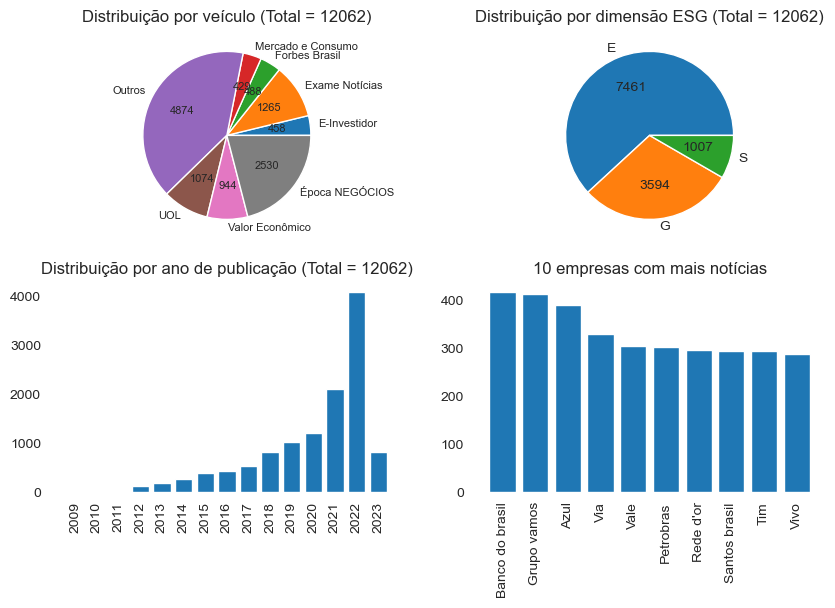

In [4]:
df = pd.read_excel('sentimento_'+base_noticias)
sns.set_style("white")
# agrupando por fonte, dimensao e datas
dfFontes  = df.groupby("fonte").count().reset_index(drop=False)
dfFontes['fonte'] = dfFontes.apply(lambda row : 'Outros' if row['titulo'] < 0.03 * np.sum(dfFontes['titulo']) else row['fonte'] , axis=1)
dfFontes  = dfFontes.groupby("fonte").sum() 
dfDimensoes  = df.groupby("classificacao").count()
dfAnos = df.set_index("data_publicacao").groupby([pd.Grouper(freq="Y")]).count().sort_index()
dfEmpresas  = df.groupby("empresa").count().sort_values(by=['titulo'], ascending=False).reset_index(drop=False)

plt.figure(figsize = (10, 6))
plt.subplot(2, 2, 1)
plt.pie(dfFontes['titulo'], labels=dfFontes.index, autopct=lambda p: '{:.0f}'.format(p * np.sum(dfFontes['titulo']) / 100),  textprops={'fontsize': 8})
plt.title('Distribuição por veículo (Total = '  + str(np.sum(dfFontes['titulo']))+ ')' )

plt.subplot(2, 2, 2)
plt.pie(dfDimensoes['titulo'], labels=dfDimensoes.index, autopct=lambda p: '{:.0f}'.format(p * np.sum(dfDimensoes['titulo']) / 100))
plt.title('Distribuição por dimensão ESG (Total = '  + str(np.sum(dfDimensoes['titulo']))+ ')' )

plt.subplot(2, 2, 3)
y_pos = np.arange(len(dfAnos.index))
plt.bar(y_pos, dfAnos['titulo']  )
plt.box(False)
plt.xticks(y_pos, dfAnos.index.year, rotation=90)
plt.title('Distribuição por ano de publicação (Total = '  + str(np.sum(dfDimensoes['titulo']))+ ')' )

plt.subplot(2, 2, 4)
y_pos = np.arange(10)
plt.bar(y_pos, dfEmpresas.head(10)['titulo']  )
plt.box(False)
plt.xticks(y_pos, dfEmpresas.head(10)['empresa'].str.capitalize(), rotation=90)
plt.title('10 empresas com mais notícias' )

plt.show()

## Definindo a empresa para análise específica

In [17]:
empresa = 'lojas americanas'
dfEmpresa = df[df['empresa'] == empresa]

## Análise de frequencia e distribuição para a empresa

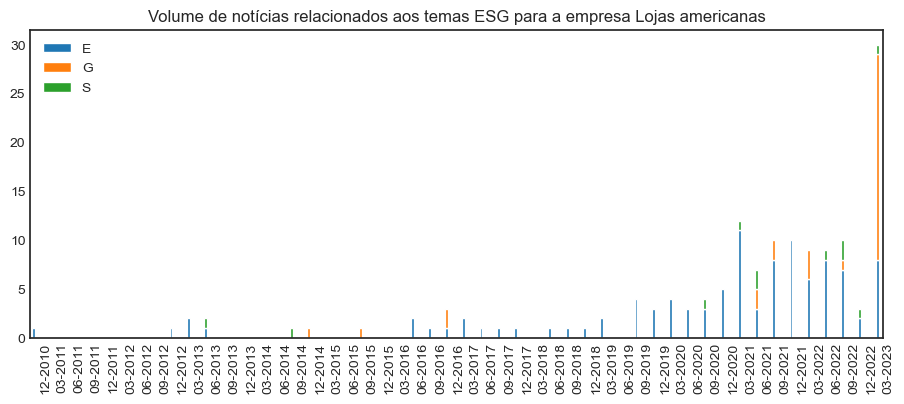

In [18]:
# agrupamento dos dados por data e categoria

dfCategoria = dfEmpresa.set_index("data_publicacao").groupby([pd.Grouper(freq="Q"), "classificacao"]).count()

# criação do gráfico de barras empilhadas
dfCategoria = dfCategoria['titulo'].unstack()  
dfCategoria = dfCategoria.asfreq('M')
ax = dfCategoria.plot.bar( stacked=True, figsize=(11,4))
ax.legend(title='')
labels = [tick.strftime('%m-%Y') if tick.month%3==0 else '' for tick in dfCategoria.index ]
ax.set_xticks(np.linspace(start=1, stop=len(labels), num=len(labels)))
ax.set_xticklabels(labels, rotation=90, ha='left')
ax.set_xlabel('')
ax.set_title('Volume de notícias relacionados aos temas ESG para a empresa '+empresa.capitalize())
plt.show()

## Visualização do sentimento para a empresa

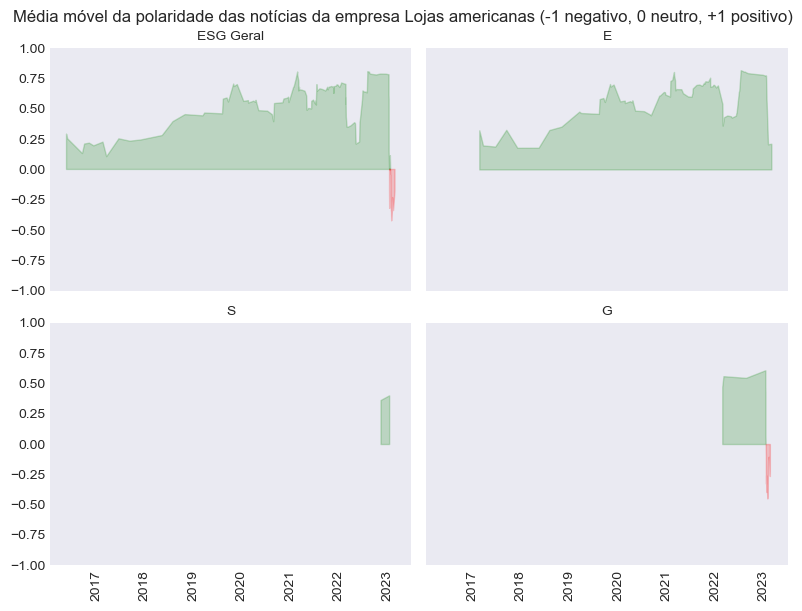

In [7]:
plt.style.use('seaborn-dark')

ldfVisoesESG = [dfEmpresa]
llabelVisoesESG = ['ESG Geral']

for l in 'ESG':
    ldfVisoesESG.append(dfEmpresa[dfEmpresa['classificacao'] == l])
    llabelVisoesESG.append(l)
for d in ldfVisoesESG:
    d['media'] = d.rolling(10)['polaridade'].mean()
    
# plotando o gráfico com a média móvel
fig, ax = plt.subplots(2,2, figsize=(8, 6), sharex=True, sharey=True)
l = 0
for i in range(0,2):
    for j in range (0,2):
        ax[i,j].plot(ldfVisoesESG[l]['data_publicacao'], ldfVisoesESG[l]['media'], label='Média Móvel', color='black', linewidth=0)
        # ajustando o visual do gráfico
        ax[i,j].set_title(llabelVisoesESG[l], fontsize=10)
        ax[i,j].fill_between(ldfVisoesESG[l]['data_publicacao'], 0 , ldfVisoesESG[l]['media'], interpolate=True, where=ldfVisoesESG[l]['media']>0, color='green', alpha=0.2)
        ax[i,j].fill_between(ldfVisoesESG[l]['data_publicacao'], 0 , ldfVisoesESG[l]['media'], interpolate=True,  where=ldfVisoesESG[l]['media']<0, color='red', alpha=0.2)
        ax[i,j].tick_params(axis='x', labelrotation=90)
        l = l+1
plt.tight_layout()
plt.ylim(-1, 1)
fig.suptitle('Média móvel da polaridade das notícias da empresa '+empresa.capitalize()+' (-1 negativo, 0 neutro, +1 positivo)', y=1.01)
plt.show()

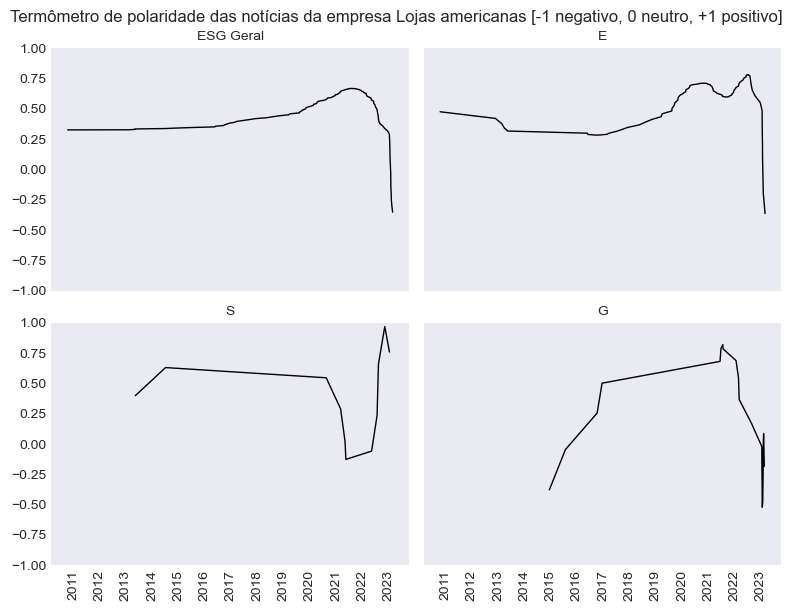

In [8]:
dfPolaridade = dfEmpresa

def gera_curva_polaridade_media(dfNoticiasComPolaridade, empresa, dimensao, maxima_data=None):
    dfPolaridade = dfNoticiasComPolaridade
    
    if maxima_data is not None:
        dfPolaridade = dfPolaridade[dfPolaridade['data_publicacao'].dt.date <= maxima_data]
    
    if empresa != '':
        dfPolaridade = dfPolaridade[dfPolaridade['empresa'] == empresa]
    if dimensao != '' and dimensao != 'ESG':
        dfPolaridade = dfPolaridade[dfPolaridade['classificacao'] == dimensao]
        
    dfPolaridade['data_publicacao'] = pd.to_datetime(pd.to_datetime(dfPolaridade['data_publicacao']).dt.date)
    dfPolaridade = dfPolaridade.set_index('data_publicacao')
    dfPolaridade = dfPolaridade.groupby(by='data_publicacao').agg({'polaridade' : 'sum', 'titulo': 'count'})
    #dfPolaridade = dfPolaridade.set_index('data_publicacao').groupby([pd.Grouper(freq="Q")]).agg({'polaridade' : 'sum', 'titulo': 'count'})
    dfPolaridade['polaridade'] = dfPolaridade['polaridade'] / dfPolaridade['titulo']
    dfPolaridade = dfPolaridade.sort_index()
    #dfPolaridade = dfPolaridade.interpolate(method='time').
    
    if len(dfPolaridade) <= 5:
        return None
    
    dfPolaridade = dfPolaridade.ewm(alpha=0.8).mean()
    c = np.polyfit( np.linspace(0,1,len(dfPolaridade))  , dfPolaridade['polaridade'], 5) #polinomio grau 5
    poly_eqn = np.poly1d(c)
    y_hat = poly_eqn(np.linspace(0,1,len(dfPolaridade)))
    dfPolaridade['polaridade_fit'] = y_hat       
    
    return dfPolaridade


plt.style.use('seaborn-dark')

ldfVisoesESG = [gera_curva_polaridade_media(df, empresa, 'ESG')]
llabelVisoesESG = ['ESG Geral']

for l in 'ESG':
    ldfVisoesESG.append( gera_curva_polaridade_media(df, empresa, l)  )
    llabelVisoesESG.append(l)
    
# plotando o gráfico com a interpolação
fig, ax = plt.subplots(2,2, figsize=(8, 6), sharex=True, sharey=True)
l = 0
for i in range(0,2):
    for j in range (0,2):
        ax[i,j].plot(ldfVisoesESG[l].index, ldfVisoesESG[l]['polaridade_fit'], label='Média Móvel', color='black', linewidth=1)
        # ajustando o visual do gráfico
        ax[i,j].set_title(llabelVisoesESG[l], fontsize=10)
        ax[i,j].tick_params(axis='x', labelrotation=90)
        ax[i,j].xaxis.set_major_locator(YearLocator() )
        ax[i,j].xaxis.set_major_formatter(DateFormatter('%Y'))
        ax[i,j].xaxis.set_minor_locator(MonthLocator())
        l = l+1
plt.tight_layout()
plt.ylim(-1, 1)
fig.suptitle('Termômetro de polaridade das notícias da empresa '+empresa.capitalize()+' [-1 negativo, 0 neutro, +1 positivo]', y=1.01)
plt.show()


## Amostra de notícias para a empresa

In [9]:
plt.style.use('seaborn-white')

def plota_timeline_polaridade(dfEmpresa, sinal, numero_noticias=2, empresa=''):
    desc = ''
    dfTimeline = dfEmpresa
    if sinal >0:
        dfTimeline = dfEmpresa[dfEmpresa['polaridade'] > 0]
        desc = 'positivas'
    else:
        dfTimeline = dfEmpresa[dfEmpresa['polaridade'] < 0]
        desc = 'negativas'
        
    dfTimeline = dfTimeline.sort_values('polaridade',ascending = False).groupby(dfTimeline.data_publicacao.dt.date).head(1).sort_values(by='data_publicacao')
    dfTimeline = dfTimeline.sort_values('polaridade',ascending = False).groupby(dfTimeline.data_publicacao.dt.year).head(numero_noticias).sort_values(by='data_publicacao')
    dates = list(dfTimeline['data_publicacao'].dt.date)
    labels = list(dfTimeline.apply(lambda row : row['titulo'] + ' [' + row['classificacao']   + ' ' + '{:.2f}'.format(row['polaridade']) +   ']'    , axis=1))
    labels = [trim_texto(l) for l in labels]

    plota_timeline(dates, labels, 'Timeline de amostra de noticias ' + desc + ' para empresa '+ empresa.capitalize() + ' (2 notícias/ano)')

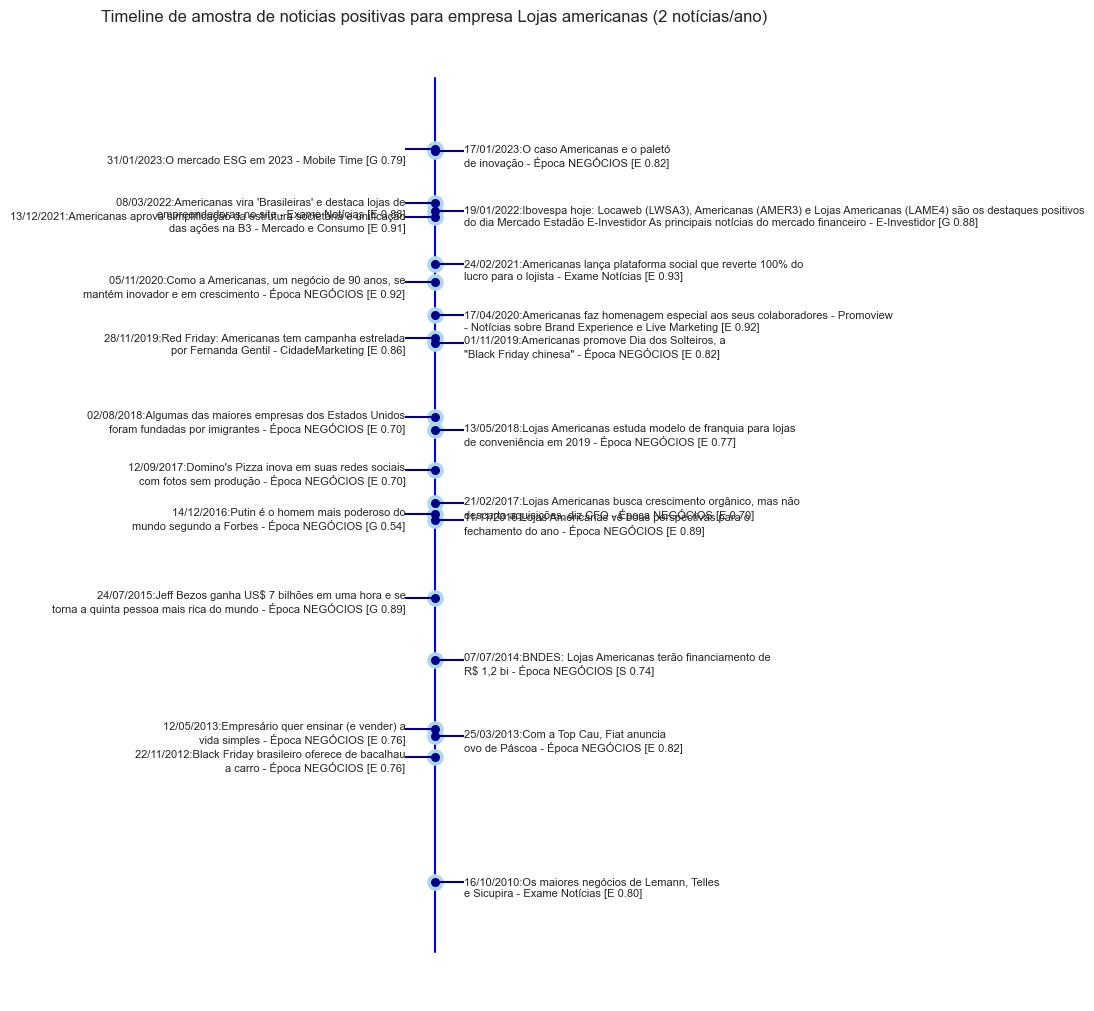

In [10]:
plota_timeline_polaridade(dfEmpresa, +1, 2, empresa )

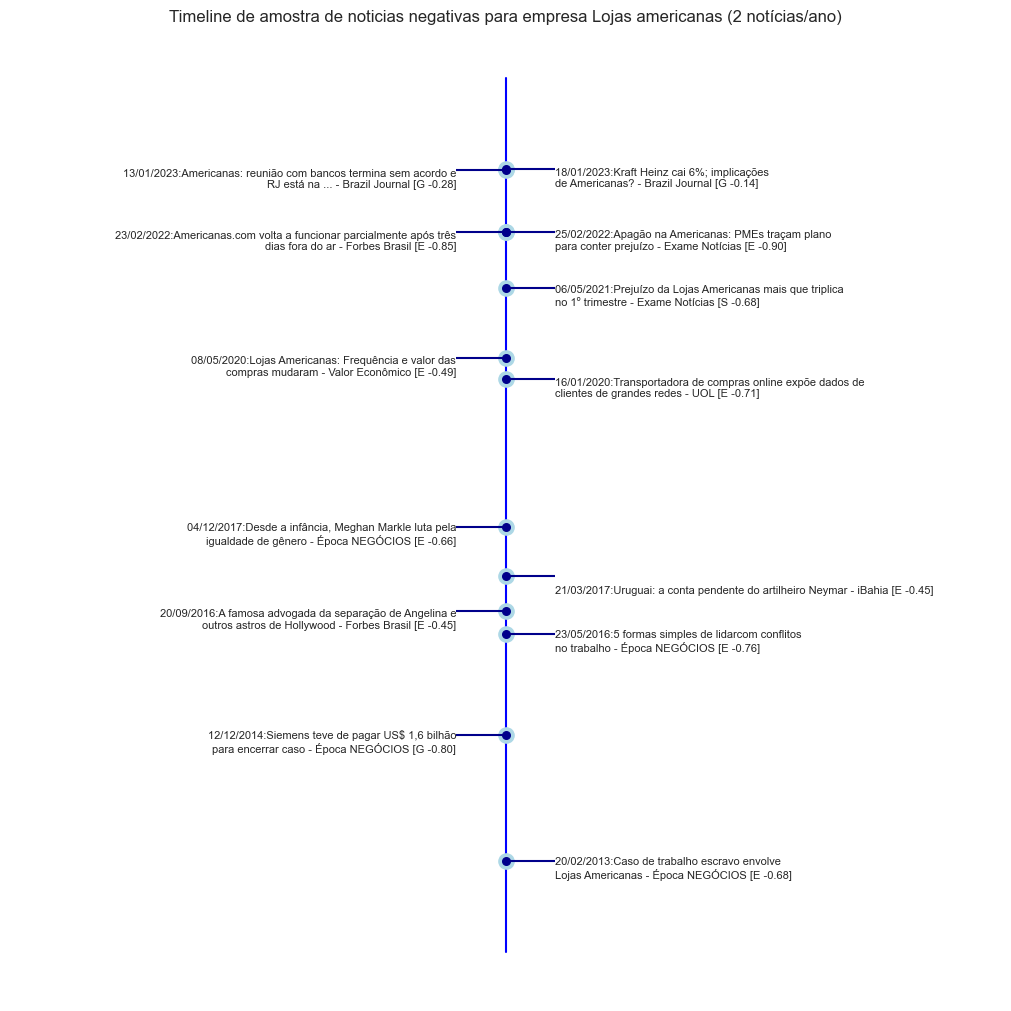

In [11]:
plota_timeline_polaridade(dfEmpresa, -1, 2, empresa )

## Comparativo entre empresas com mais notícias

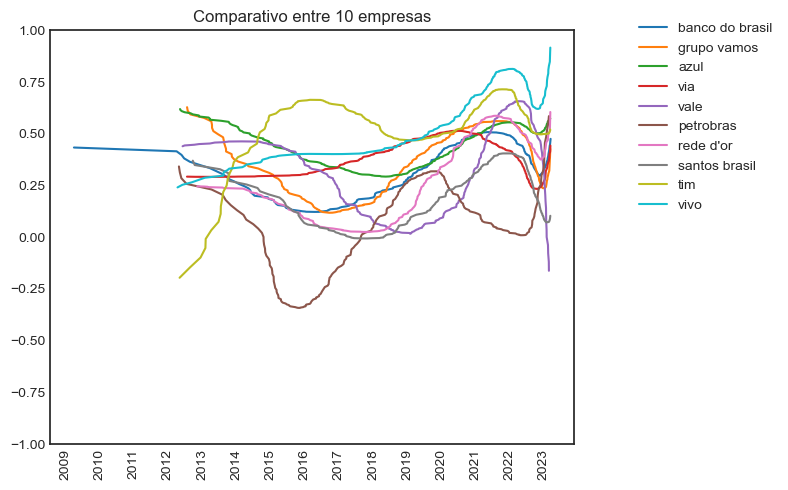

In [12]:
qtde_comparar = 10
lcomp = list(df.groupby("empresa").count().sort_values(by=['titulo'], ascending=False).reset_index(drop=False).head(qtde_comparar)['empresa'])

fig, ax = plt.subplots(figsize=(8,5))

for emp in lcomp:
    dfEmpPol = gera_curva_polaridade_media(df, emp, 'ESG')
    ax.plot(dfEmpPol.index, dfEmpPol['polaridade_fit'], label=emp,  linewidth=1.5)

    
# ajustando o visual do gráfico
ax.set_title('Comparativo entre '+str(len(lcomp))+' empresas', fontsize=12)
ax.xaxis.set_major_locator(YearLocator() )
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.xaxis.set_minor_locator(MonthLocator())
ax.tick_params(axis='x', labelrotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.05), fancybox=True)

plt.tight_layout()
plt.ylim(-1, 1)
plt.show()




## Comparativo com Polaridade x B3

In [40]:
dfB3 = None

dfEmpresasComparar = pd.read_excel('lista_empresas.xlsx')

dfEmpresasComparar = pd.merge(left=dfEmpresasComparar, right=pd.read_excel('EscoreMerco.xlsx'), on='Nome', how='left')

data_analise = dt.date(2022, 12, 31)  # ate fim de 2022

dfAnalise = df[df['data_publicacao'].dt.date <= data_analise ]

dfEmpresasComparar = dfEmpresasComparar[ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) | (~pd.isnull(dfEmpresasComparar['Escore Merco']))  ]  # somente considera B3 ou MERCO

dfEmpresasComparar['QtdeNoticias'] =  dfEmpresasComparar.apply(lambda row: len(dfAnalise[dfAnalise.empresa == remove_acentos(row['Nome'].lower())]),  axis=1)

def obtem_ultima_polaridade_base100(dfAnalise, empresa, data_analise):
    dfRes = gera_curva_polaridade_media(dfAnalise, remove_acentos(empresa.lower()), 'ESG', data_analise)
    if dfRes is not None and len(dfRes) > 0:
        return 100.0 * dfRes['polaridade_fit'].iloc[-1]
    else:
        return None
    

dfEmpresasComparar['Polaridade'] = dfEmpresasComparar.apply(lambda row: obtem_ultima_polaridade_base100(dfAnalise, row['Nome'], data_analise) if row['QtdeNoticias'] >= 10 else None   , axis=1)

# B3 x pol
dfB3Pol = dfEmpresasComparar[['Nome', 'SCORE ISE B3', 'Polaridade']][ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) &  (~pd.isnull(dfEmpresasComparar['Polaridade'])) ].drop_duplicates()
print ("B3 x Polaridade (" + str(len(dfB3Pol)) + " empresas): " + str(scipy.stats.spearmanr(dfB3Pol['SCORE ISE B3'], dfB3Pol['Polaridade'])))

# B3 x MERCO
dfB3Merco = dfEmpresasComparar[['Nome', 'SCORE ISE B3', 'Escore Merco']][ (~pd.isnull(dfEmpresasComparar['SCORE ISE B3'])) &  (~pd.isnull(dfEmpresasComparar['Escore Merco'])) ].drop_duplicates()
print ("B3 x Merco (" + str(len(dfB3Merco)) + " empresas): " + str(scipy.stats.spearmanr(dfB3Merco['SCORE ISE B3'], dfB3Merco['Escore Merco'])))

# MERCO x POL
dfMercoPol = dfEmpresasComparar[['Nome', 'Escore Merco', 'Polaridade']][ (~pd.isnull(dfEmpresasComparar['Escore Merco'])) &  (~pd.isnull(dfEmpresasComparar['Polaridade'])) ].drop_duplicates()
print ("Merco x Polaridade (" + str(len(dfMercoPol)) + " empresas): " + str(scipy.stats.spearmanr(dfMercoPol['Escore Merco'], dfMercoPol['Polaridade'])))



B3 x Polaridade (80 empresas): SpearmanrResult(correlation=0.22904360056258788, pvalue=0.04098918129695986)
B3 x Merco (30 empresas): SpearmanrResult(correlation=-0.00867630700778643, pvalue=0.9637059421012134)
Merco x Polaridade (34 empresas): SpearmanrResult(correlation=-0.10771581359816654, pvalue=0.5442750132972658)


In [41]:
dfEmpresasComparar.to_excel('comp1.xlsx')

In [38]:
dfB3Merco

,Nome,SCORE ISE B3,Escore Merco
5,Lojas Americanas,82.066470,4987.0
30,Ambev,70.366137,8264.0
39,Azul,73.595571,4424.0
46,BRF,76.192997,5148.0
52,Banco BTG Pactual,80.568781,4032.0
53,Banco Bradesco,83.254203,6977.0
65,Banco Santander,80.581159,5915.0
69,Banco do Brasil,79.340593,5026.0
98,Braskem,79.355577,4617.0
127,COPEL,81.165445,3277.0


In [39]:
dfMercoPol

,Nome,Escore Merco,Polaridade
5,Lojas Americanas,4987.0,84.867929
30,Ambev,8264.0,63.247034
39,Azul,4424.0,84.457095
46,BRF,5148.0,67.868380
51,Banco BTG Pactual,4032.0,69.203742
53,Banco Bradesco,6977.0,80.286995
64,Banco Santander,5915.0,85.707050
69,Banco do Brasil,5026.0,32.190362
96,Braskem,4617.0,65.015496
127,COPEL,3277.0,90.079996
